<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/05.%20Sarria-Sant%20Gervasi/Forecasting_(Indicador_73).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Internet)](#Analisis-por-grupo-de-indicadores-(tecnologia))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Internet)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Internet']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   6132 non-null   int64  
 1   Trimestre             6132 non-null   int64  
 2   Mes                   6132 non-null   int64  
 3   Codi_Districte        6132 non-null   int64  
 4   Nom_Districte         6132 non-null   object 
 5   Codi_Barri            6132 non-null   int64  
 6   Nom_Barri             6132 non-null   object 
 7   Compraventa_Unitario  6132 non-null   float64
 8   Internet              6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Internet
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,82.8
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,82.8


### Analisis Exploratorio

Filtramos los datos por el distrito de Sarria-Sant Gervasi -> Codi_Districte = 5

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 5]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-01-01,4198.150000,88.2
2016-02-01,4198.150000,88.2
2016-03-01,4198.150000,88.2
2016-04-01,4246.083333,88.2
2016-05-01,4246.083333,88.2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  84 non-null     float64
 1   Internet              84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


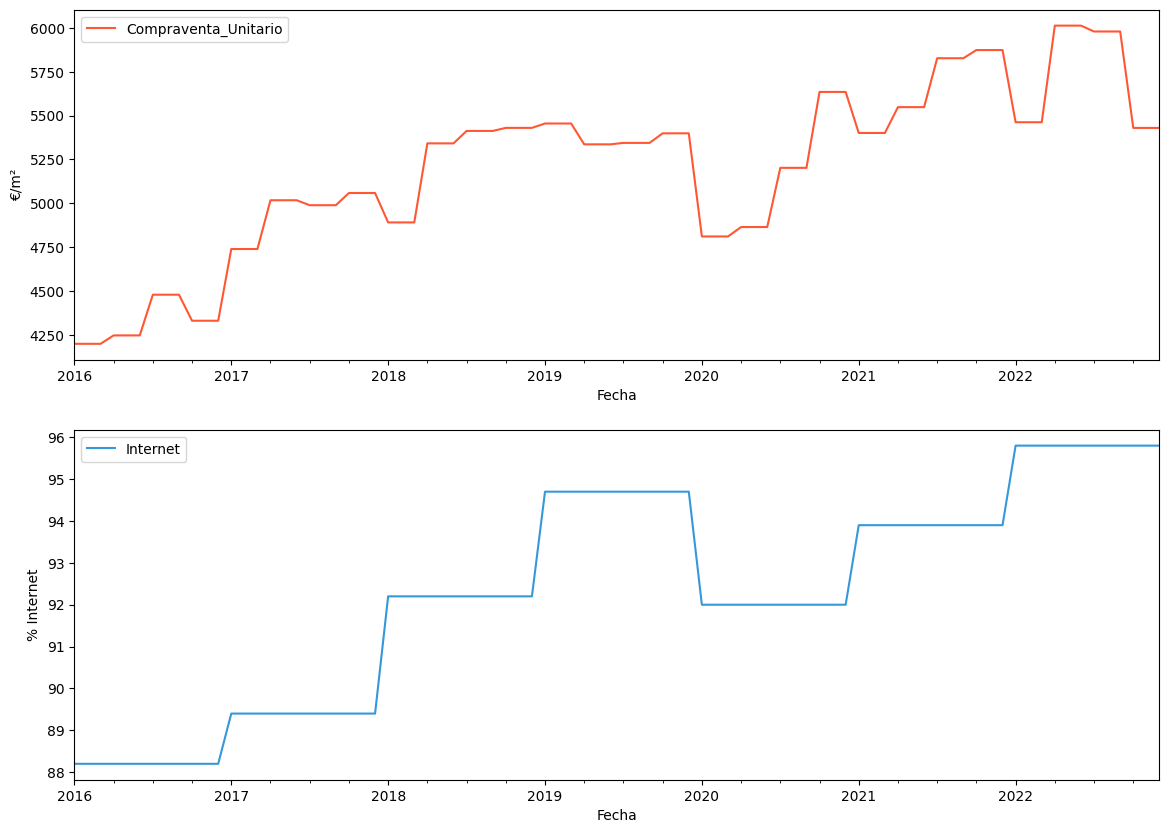

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Internet']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Internet
Compraventa_Unitario,1.000000,0.840738
Internet,0.840738,1.000000


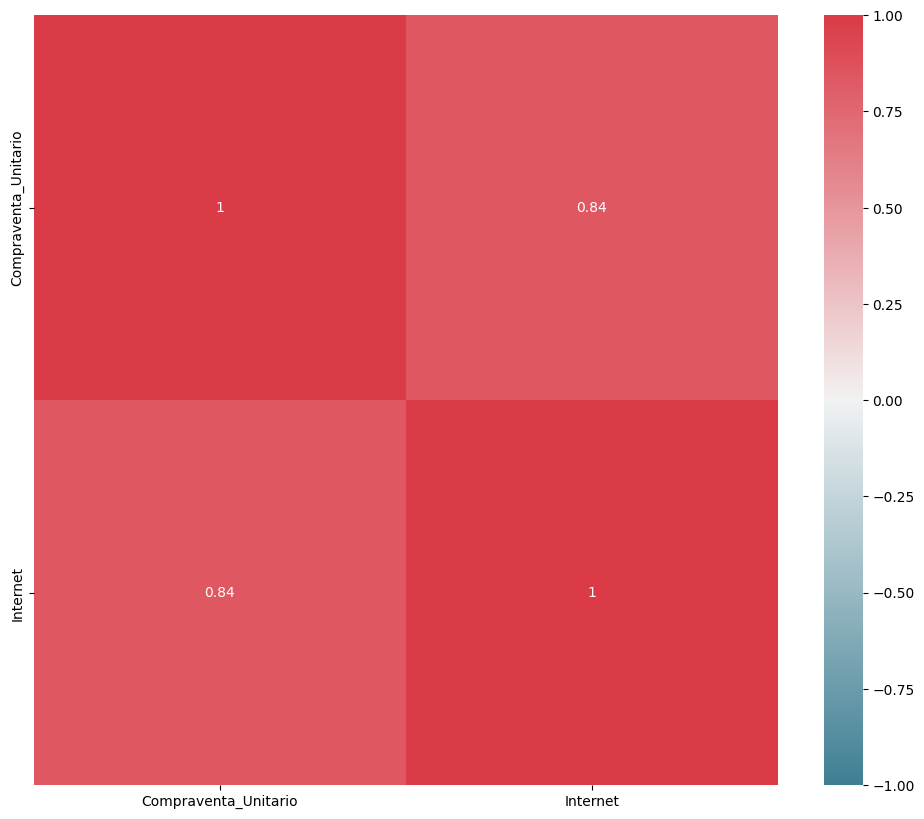

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "Internet" es de 0.840738, lo que sugiere una correlación muy alta entre estas dos variables en el modelo.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [17]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(72, 2) (12, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [18]:
import statsmodels.tsa.stattools as sts

In [19]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.517061
Serie de tiempo Internet
p-value: 0.560341


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [20]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,47.933333,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


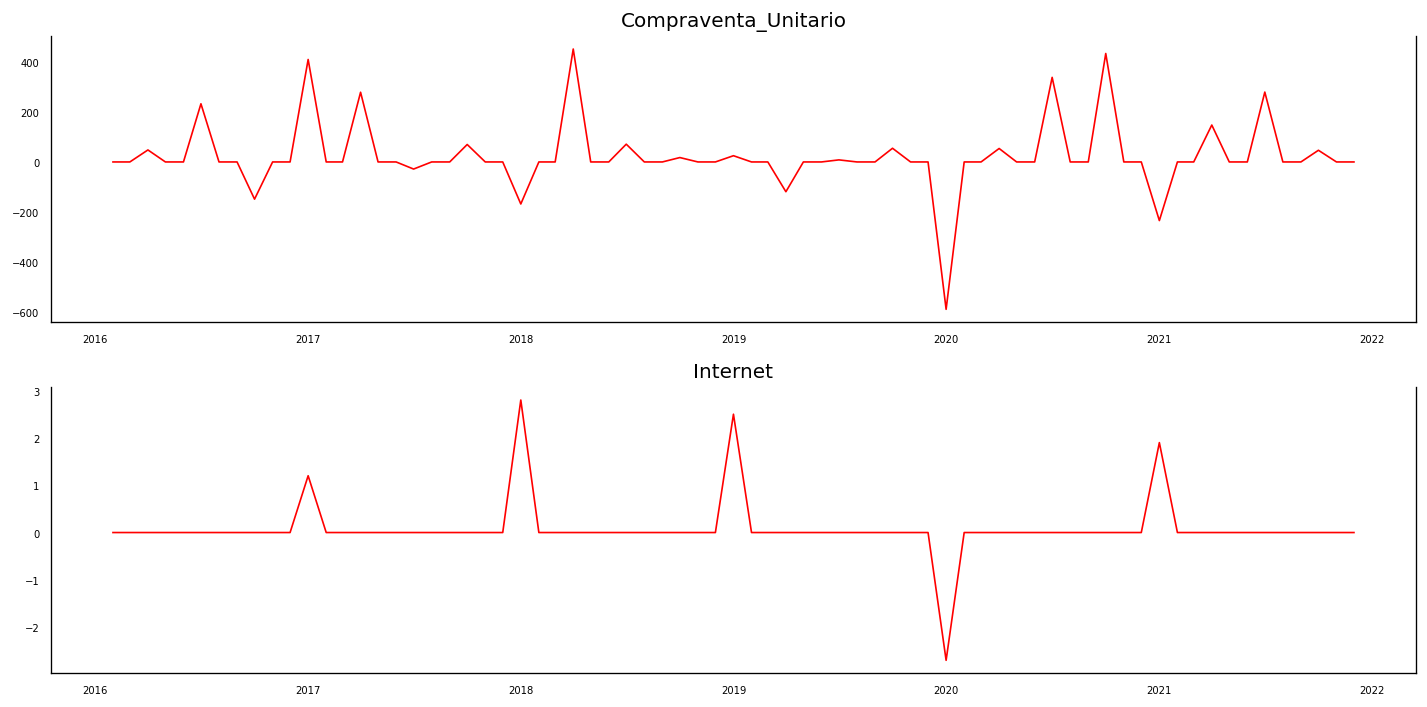

In [21]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [22]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Internet
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

In [23]:
from statsmodels.tsa.api import VAR

In [24]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [36]:
modelsel=model.select_order(16)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,9.113*,9.186*,9072.*,9.141*
1,9.258,9.477,1.049e+04,9.342
2,9.402,9.767,1.213e+04,9.544
3,9.466,9.977,1.295e+04,9.664
4,9.611,10.27,1.502e+04,9.865
5,9.756,10.56,1.744e+04,10.07
6,9.801,10.75,1.838e+04,10.17
7,9.945,11.04,2.145e+04,10.37
8,10.09,11.33,2.512e+04,10.57
9,9.778,11.17,1.873e+04,10.31


Los criterios de selección de modelo como AIC, BIC, FPE y HQIC se utilizan para elegir el mejor orden de un modelo VAR. En este caso, el orden de rezago 0 muestra los valores mínimos en todos los criterios, lo que sugiere que es la opción preferida para el modelo. Esto implica que un modelo VAR sin rezagos es el más adecuado según estos criterios de evaluación.

Se adopta VAR(12)

#### Ajustando el modelo

In [50]:
res = model.fit(maxlags=12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     16:01:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.6781
Nobs:                     59.0000    HQIC:                   10.6048
Log likelihood:          -410.000    FPE:                    22730.8
AIC:                      9.91748    Det(Omega_mle):         11214.0
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           32.970286        25.701196            1.283           0.200
L1.Compraventa_Unitario         -0.043306         0.155680           -0.278           0.781
L

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Internet" es de 0.184071, lo que sugiere una correlación leve entre los residuos de estas dos variables en el modelo.

In [51]:
X_train.columns

Index(['Compraventa_Unitario', 'Internet'], dtype='object')

###### Causalidad de Granger

In [52]:
grangercaus=res.test_causality(['Internet'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.487,1.897,0.151,"(12, 68)"


In [53]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Internet'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.6076,1.897,0.828,"(12, 68)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [63]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Internet_x
Compraventa_Unitario_y,1.0000,0.2775
Internet_y,0.0009,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [64]:
residuals=res.resid

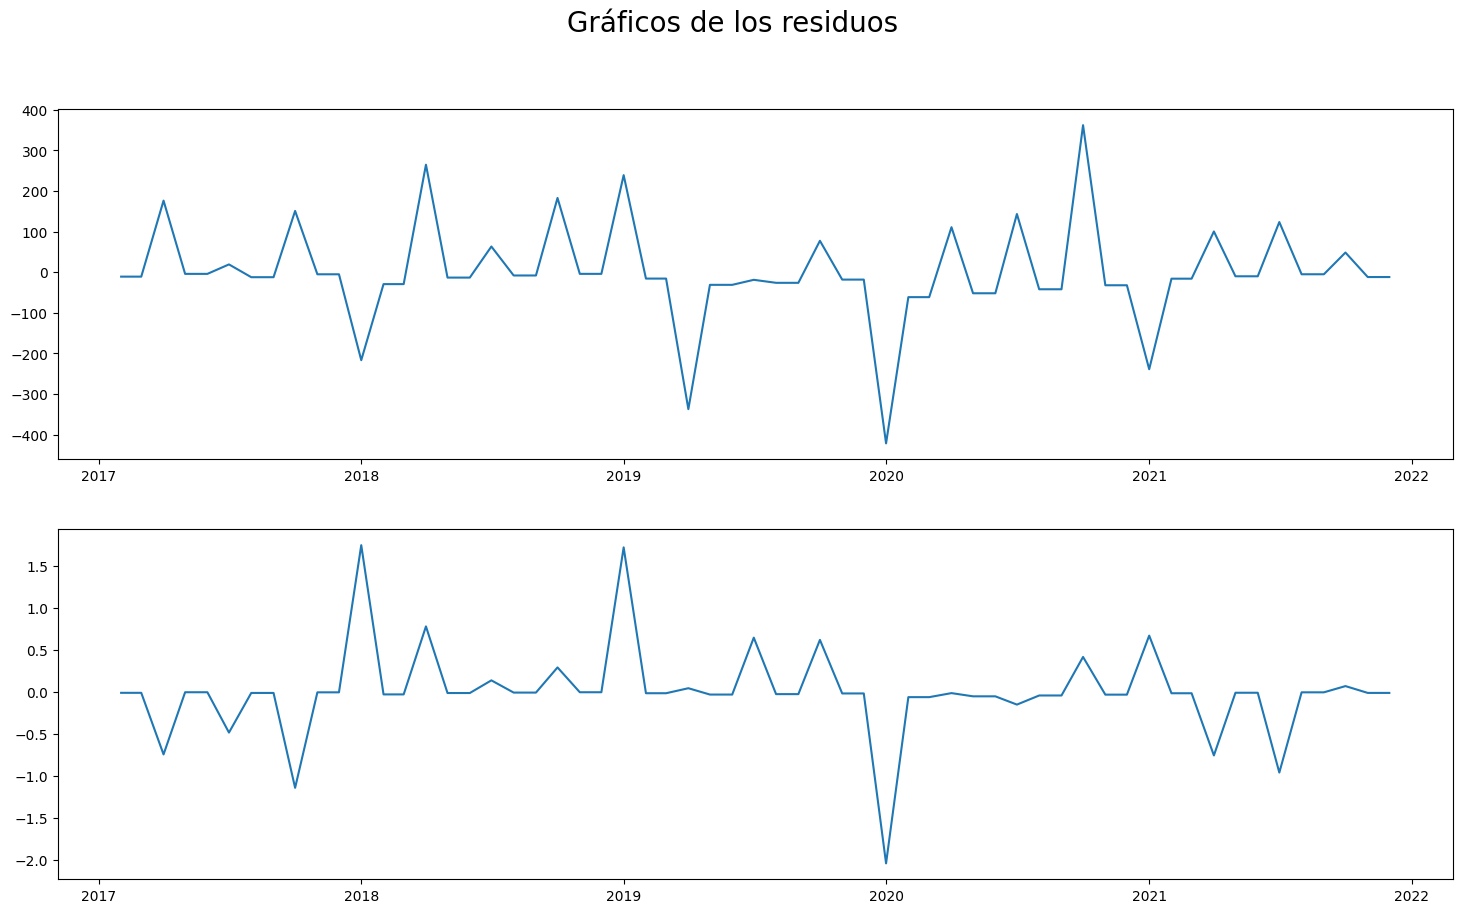

In [65]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [66]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[3.848836603924706e-11, 4.7179635865325466e-11]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 3 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


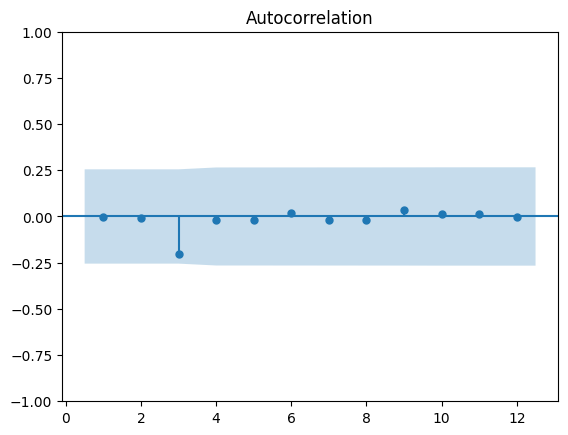

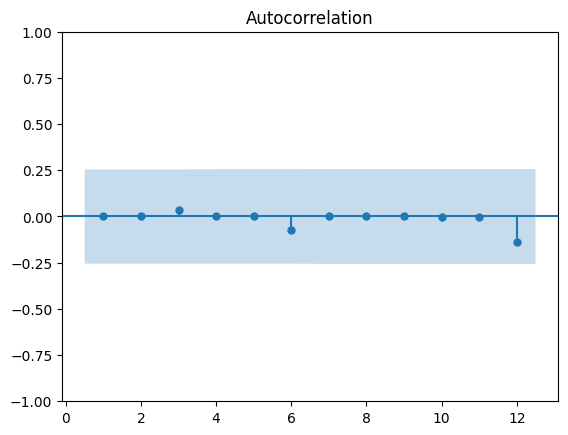

In [67]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


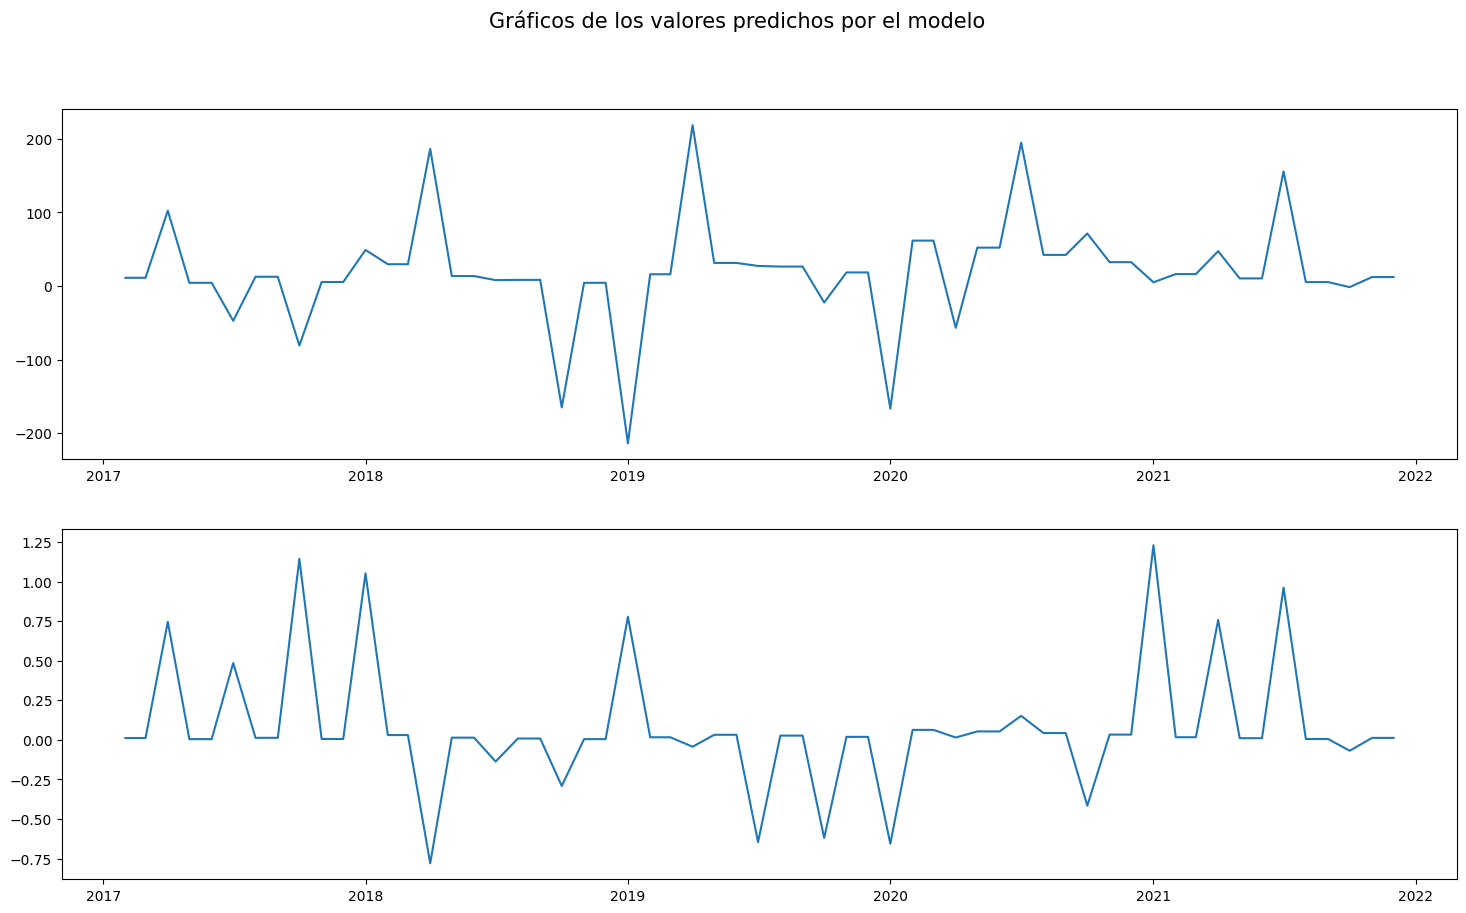

In [68]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [69]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,Internet_pred
Fecha,,
2022-01-01,-224.949338,0.349843
2022-02-01,29.005477,0.029563
2022-03-01,27.725264,0.028258
2022-04-01,96.189480,0.609601
2022-05-01,24.518534,0.058112
2022-06-01,23.686429,0.055802
2022-07-01,155.654898,-0.039051
2022-08-01,17.773346,0.075359
2022-09-01,17.398178,0.072736


<Figure size 1200x1000 with 0 Axes>

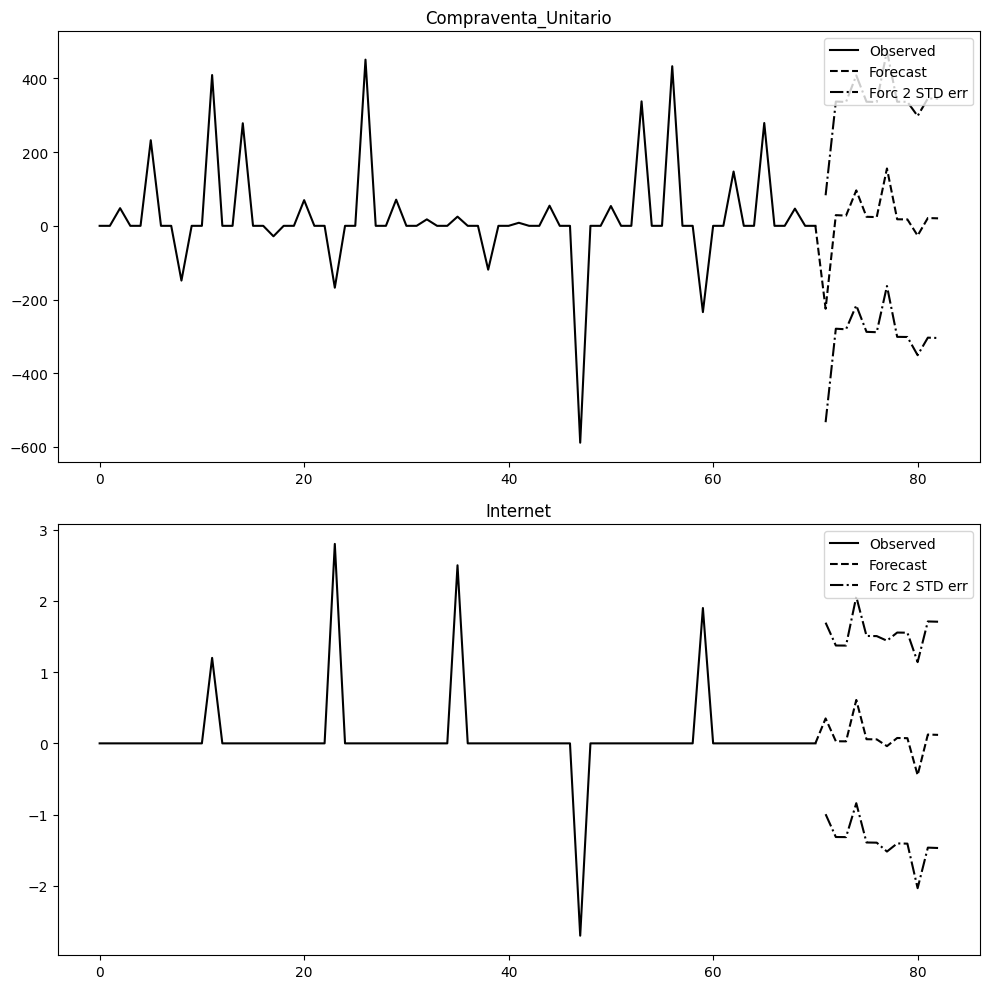

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [71]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [72]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Internet
Fecha,,
2022-01-01,5649.267329,94.249843
2022-02-01,5678.272806,94.279406
2022-03-01,5705.998070,94.307664
2022-04-01,5802.187549,94.917265
2022-05-01,5826.706083,94.975376
2022-06-01,5850.392512,95.031178
2022-07-01,6006.047410,94.992127
2022-08-01,6023.820757,95.067485
2022-09-01,6041.218935,95.140221


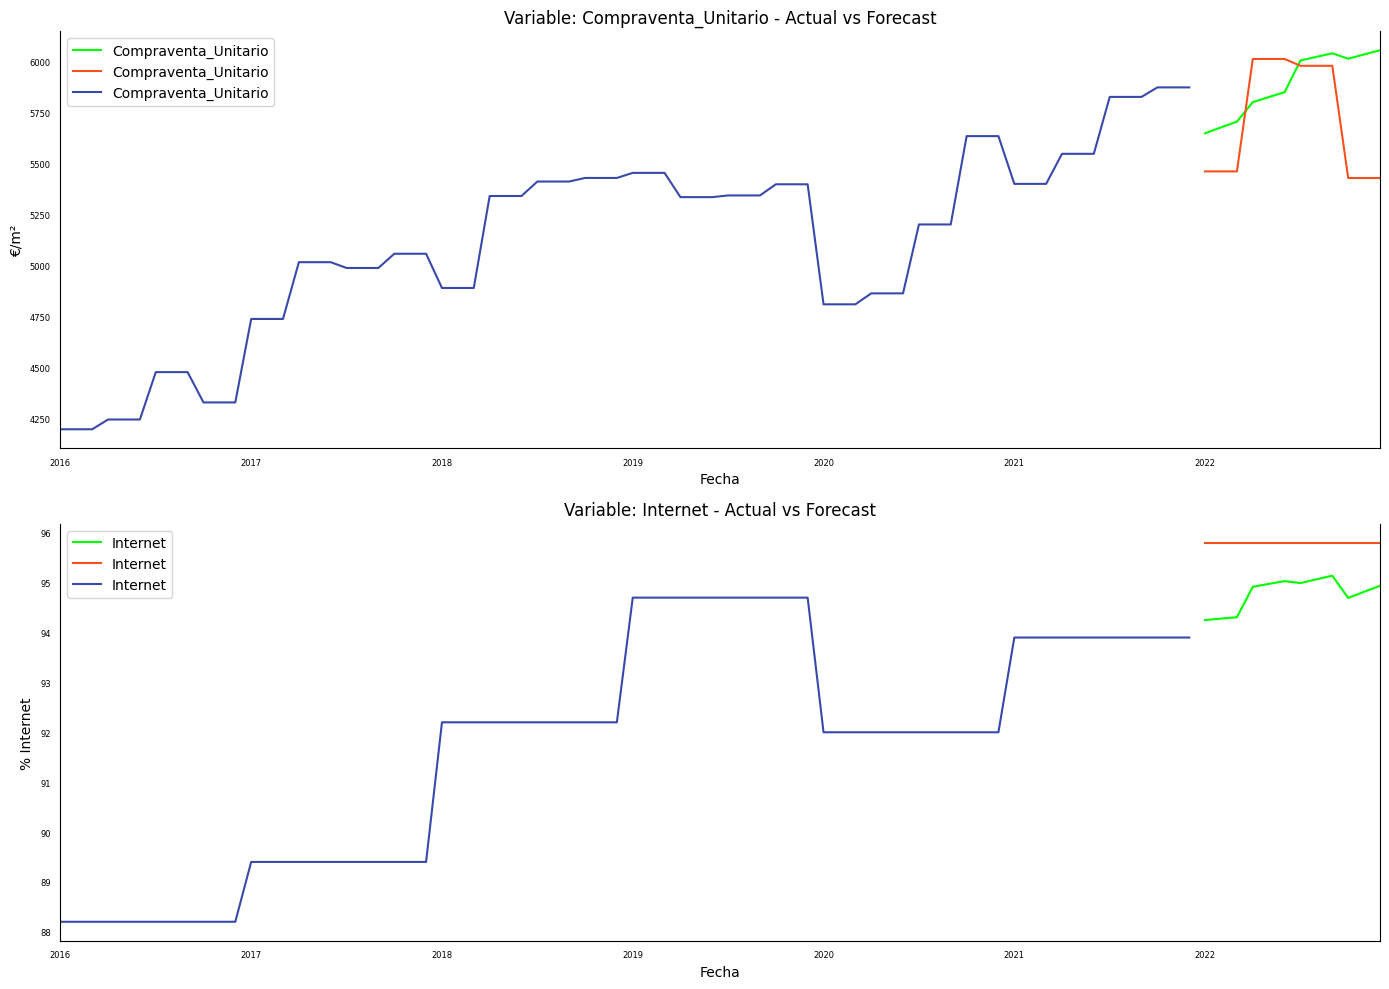

In [73]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Internet']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [74]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [75]:
for i in ['Compraventa_Unitario','Internet']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 112863.38609620626
MAE is : 262.930357077377
RMSE is : 335.95146389948394
MAPE is : 4.734225033226962
R2 is : -0.48357370796137267

Evaluation metric for Internet
Evaluation metric results:-
MSE is : 1.129228484525682
MAE is : 1.0159242423638293
RMSE is : 1.0626516289573371
MAPE is : 1.0604637185426193
R2 is : 0.0



Los resultados de la evaluación muestran que el modelo para la variable "Compraventa_Unitario" tiene un desempeño subóptimo, con un alto error cuadrático medio (MSE) de 112863.39 y un coeficiente de determinación (R2) negativo, lo que sugiere que el modelo no explica bien la variabilidad de los datos. El error absoluto medio (MAE) y el error porcentual absoluto medio (MAPE) también son altos, indicando una discrepancia significativa entre las predicciones y los valores reales. Por otro lado, el modelo para la variable "Internet" parece tener un mejor desempeño, con MSE, MAE y MAPE bajos, aunque el R2 es nulo, lo que indica que el modelo no explica la variabilidad de los datos. En resumen, se requiere una revisión y posible mejora del modelo para "Compraventa_Unitario", mientras que el modelo para "Internet" puede necesitar ajustes adicionales para capturar mejor la variabilidad de los datos.

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 131.9731406598704
Root mean squared error: 237.55474666346996


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [77]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [78]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(72, 2) (12, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [79]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.517061
Serie de tiempo Internet
p-value: 0.560341


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [80]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,47.933333,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


In [81]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Internet
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [82]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [83]:
cointegration_test(X_train_transformed[['Compraventa_Unitario', 'Internet']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  28.67     > 12.3212   =>   True
Internet >  8.78      > 4.1296    =>   True


- Para la variable "Compraventa_Unitario": El valor del estadístico de prueba es 28.67, que supera el valor crítico de 12.3212 para un nivel de significancia del 95%. Por lo tanto, se rechaza la hipótesis nula de que "Compraventa_Unitario" no causa Granger a ninguna de las otras variables incluyendo a "Internet".

- Para la variable "Internet": El valor del estadístico de prueba es 8.78, que supera el valor crítico de 4.1296 para un nivel de significancia del 95%. Por lo tanto, se rechaza la hipótesis nula de que "Internet" no causa Granger a ninguna de las otras variables incluyendo a "Compraventa_Unitario".

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [84]:
import pmdarima as pm

In [85]:

pq = []
for name in ['Compraventa_Unitario', 'Internet']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=905.170, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=907.170, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=907.170, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=909.170, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=905.121, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=907.060, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=907.056, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.089 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : Internet
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=133.328, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=135.328, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : A

#####Seleccion del modelo

In [86]:
pq

[(0, 0, 0), (0, 0, 0)]

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En este caso no se puede aplicar el modelo VARMAX, ya que el modelo esta considerando unicamente la tendencia lineal y no esta incorporando autocorrelacion en los residuos del modelo.

Por lo que para estos datos, no es posible entrenar un modelo VARMAX

##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de Nou Barris de Barcelona entre las dos series temporales de Compraventa_unitario y Internet, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del primer orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede causar las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- No se a podido aplicar el modelo VARMAX, por la nula autocorrelacion de los datos.

Con los datos obtenidos unicamente se ha podido entrenar un modelo VAR.

